In [1]:
!gdown --id '1CsQ2ysdk_IDPUAos87ssKUXAv8iXxm2k' --output /tmp/Dataset.zip

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1CsQ2ysdk_IDPUAos87ssKUXAv8iXxm2k
To: /tmp/Dataset.zip
100% 348k/348k [00:00<00:00, 84.6MB/s]


In [2]:
import os
import zipfile

local_zip = '/tmp/Dataset.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall(path='/tmp')
zip_ref.close()

In [4]:
%cd ..
%cd tmp

/
/tmp


Epoch 001: LOSS = 1.0644896235724974
Epoch 002: LOSS = 1.0231163255495477
Epoch 003: LOSS = 0.9954371969379205
Epoch 004: LOSS = 0.9757193613547169
Epoch 005: LOSS = 0.9603102706257928
Epoch 006: LOSS = 0.9471710495628429
Epoch 007: LOSS = 0.9352533413334756
Epoch 008: LOSS = 0.9240425307813145
Epoch 009: LOSS = 0.9132907094516209
Epoch 010: LOSS = 0.9028776848594204
Epoch 011: LOSS = 0.8927431671099235
Epoch 012: LOSS = 0.8828548532014393
Epoch 013: LOSS = 0.8731936751992995
Epoch 014: LOSS = 0.8637470170840775
Epoch 015: LOSS = 0.8545055770895360
Epoch 016: LOSS = 0.8454618901365141
Epoch 017: LOSS = 0.8366096089717792
Epoch 018: LOSS = 0.8279431360795989
Epoch 019: LOSS = 0.8194574211539284
Epoch 020: LOSS = 0.8111478392742093
Epoch 021: LOSS = 0.8030101103145593
Epoch 022: LOSS = 0.7950402408179126
Epoch 023: LOSS = 0.7872344791350662
Epoch 024: LOSS = 0.7795892791324900
Epoch 025: LOSS = 0.7721012699434440
Epoch 026: LOSS = 0.7647672303141568
Epoch 027: LOSS = 0.7575840666503584
E

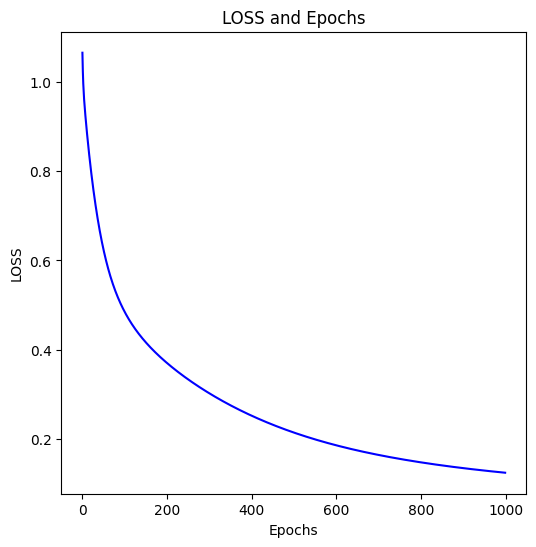

In [6]:
#自訂隱藏層+Entropy
import numpy as np
import math
import csv
import random
from matplotlib import pyplot as plt

def dlogsig(n,a):

    return a * (1-a)

def logsig(n):

    return 1 / (1 + np.exp(-1*n))

def purelin(n):

    return n

def dpurelin(n, a):

    return np.ones(np.size(n))

def softmax(in_vector):
  in_vector -= np.max(in_vector, axis=1, keepdims=True)
  in_vector = np.exp(in_vector)/np.sum(np.exp(in_vector), axis=1, keepdims=True)
  return in_vector

def add_bias(SUMs, bias):
  for row in SUMs:
    for col in row:
      col += random.uniform(-bias, bias)
  return SUMs

def weight_update(Input, weights, apha, bias, Target):
    SUMs = []
    A = [Input]
    DELTAs = []
    for weight in range(0, len(weights)):
      if weight == len(weights)-1:
        #最後一層，即輸出層，Aout
        sum = A[weight] @ weights[weight]
        SUMs.append(sum)
        A.append(softmax(add_bias(sum, bias)))
      else:
        sum = A[weight] @ weights[weight]
        SUMs.append(sum)
        A.append(logsig(add_bias(sum, bias)))


    #先計算最後的Delta
    Last_Delta = []
    #Aout = A[0][-1]
    #print("len", A[-1][0])
    for index in range(0, len(A[-1][0])):
      #注意負梯度
      if Target[0][index] == 1:
        Last_Delta.append(1 - A[-1][0][index] )
      else:
        Last_Delta.append(-1 * A[-1][0][index])
    Last_Delta = np.array([Last_Delta], dtype="float64")
    #print(Last_Delta)

    DELTAs.append(Last_Delta)

    #計算其他Delta
    for delta in range(1, len(SUMs)):
      #DELTAs = [DELTA3 DELTA2 DELTA1]
      #A = [Input A1 A2 A3]
      #SUMs = [SUM1 SUM2 SUM3]
      #weights = [W1 W2 W3]
      #DELTAs[N] = (DELTA[N-1] @ np.transpose(weights[N+1])) * dlogsig(SUM[N], A[N+1])
      DELTAs.append((DELTAs[delta-1] @ np.transpose(weights[len(A)-delta-1]) * dlogsig(SUMs[len(SUMs)-delta-1], A[len(A)-delta-1])))
      #print(DELTAs[-1])
    for weight in range(0, len(weights)):
      weights[weight] = weights[weight] + apha * np.transpose(np.transpose(DELTAs[len(DELTAs)-weight-1]) @ A[weight])

    return weights


def classify(Aout):
  max = Aout[0]
  max_index = 0
  for num in range(0, len(Aout)):
    if Aout[num] > max:
      max = Aout[num]
      max_index = num

  return max_index+1

def train_model(Input, Target, layers_and_neurons, learning_rate, bias, classify_amounts, epochs):
  apha = learning_rate
  epochs = epochs
  #注意矩陣維度輸入時的完整性
  weights = []
  neuron_every_layer = []
  neuron_every_layer.append([len(Input[0]), layers_and_neurons[0]])
  for layer in range(0, len(layers_and_neurons)-1):
    neuron_every_layer.append([layers_and_neurons[layer], layers_and_neurons[layer+1]])
  neuron_every_layer.append([layers_and_neurons[-1], classify_amounts])

  #權重初始化
  for n in neuron_every_layer:
    rows, cols = n
    w = []
    for row in range(0, rows):
      a_row = []
      for col in range(0, cols):
        a_row.append(random.uniform(-1, 1))
      w.append(a_row)
    w = np.array(w, dtype="float64")
    weights.append(w)

  LOSS_every_epoch = []
  for epoch in range(0, epochs):
    #一次epoch
    LOSS = [0]
    for data in range(0, 75):
      weights = weight_update([Input[data]], weights, apha, bias, [Target[data]])
      Aout = logsig([Input[data]]@weights[0])
      for i in range(1, len(weights)-1):
        Aout = logsig(Aout@weights[i])

      Aout = softmax(Aout@weights[-1])
      #print(np.sum(Aout))
      for classify_index in range(0, len(LOSS)):
        target_index = 0
        for i in range(0, len(Target[data])):
          if Target[data][i] == 1:
            target_index = i
            break
        LOSS[classify_index] += -1*math.log(Aout[0][target_index])



    LOSS = (sum(LOSS))/(75)
    print("Epoch {:03}".format(epoch+1) + ":", "LOSS = {:.16f}".format(LOSS))
    LOSS_every_epoch.append(LOSS)

  #Test Data
  correct = 0
  outputs = []
  for data in range(75, 150):
    Aout = logsig([Input[data]]@weights[0])
    for i in range(1, len(weights)-1):
      Aout = logsig(Aout@weights[i])
    Aout = softmax(Aout@weights[-1])
    output = [Aout[0]]
    res = classify(Aout[0])
    if res == classify(Target[data]):
      output.append("True")
      correct += 1
    else:
      output.append("False")
    outputs.append(output)
  success = correct/75

  return success, LOSS_every_epoch, outputs

def read_Input_Target():
  Input = []
  #讀取CSV input
  with open('iris_in.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
      Input.append(row)
  Input = np.array(Input, dtype="float64")

  Target = []
  #讀取CSV target
  with open('iris_out.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
      #改為機率
      if int(row[0][0]) == 1:
        Target.append([1, 0, 0])
      elif int(row[0][0]) == 2:
        Target.append([0, 1, 0])
      elif int(row[0][0]) == 3:
        Target.append([0, 0, 1])
      else:
        print("error occur when read target")
  Target = np.array(Target, dtype="float64")
  return Input, Target

if __name__ == '__main__':

  Input, Target = read_Input_Target()
  layers_and_neurons = [14]
  learning_rate = 0.005
  bias = 0.1
  classify_amounts = 3
  epochs = 1000
  success, RMSE_every_epoch, outputs = train_model(Input, Target, layers_and_neurons, learning_rate, bias, classify_amounts, epochs)

  #輸出test data的輸出結果
  print()
  for output in range(0, len(outputs)):
    print("資料" + "{:03}".format(output+76) + ":", end=' ')
    for index in outputs[output][0]:
      print("{:20.16f}".format(index), end=' ')
    print("Target:", int(classify(Target[output])), "Hit:", outputs[output][1])
  print(success)

  #劃出RMSE-Epochs圖
  plt.rcParams["figure.figsize"] = (6,6)
  plt.plot(RMSE_every_epoch,color = 'b')
  plt.title('LOSS and Epochs')
  plt.ylabel('LOSS')
  plt.xlabel('Epochs')
  plt.show()




In [ ]:
#1層隱藏層+Entropy
import numpy as np
import csv
import math
import random
from matplotlib import pyplot as plt

def dlogsig(n,a):

    return a * (1-a)

def logsig(n):

    return 1 / (1 + np.exp(-1*n))

def purelin(n):

    return n

def dpurelin(n, a):

    return np.ones(np.size(n));

def softmax(in_vector):
  in_vector -= np.max(in_vector, axis=1, keepdims=True)
  in_vector = np.exp(in_vector)/np.sum(np.exp(in_vector), axis=1, keepdims=True)
  return in_vector

def weight_update(Input, Whid, Wout, apha, Target):
    bias = 0.01
    SUMhid = Input @  Whid
    Ahid =  logsig(SUMhid)
    print(Ahid, Wout)
    SUMout = Ahid @ Wout
    Aout = softmax(SUMout)
    DELTAout = []
    for i in range(0, len(Aout[0])):
      if Target[0][i] == 1:
        DELTAout.append(Aout[0][i] -1)
      else:
        DELTAout.append(Aout[0][i])
    DELTAout = np.array([DELTAout], dtype="float64")
    DELTAhid = DELTAout @ np.transpose(Wout)
    Wout = Wout + np.transpose(np.transpose(DELTAout) @ Ahid)*apha
    Whid = Whid + np.transpose(np.transpose(DELTAhid*dlogsig(SUMhid, Ahid+bias)) @ Input)*apha

    return Whid, Wout

def print_matrix(matrix):
  for row in matrix:
    for col in row:
      print(col, end=' ')
    print()
  print()
  print()

def classify(Aout):
  max = Aout[0]
  max_index = 0
  for num in range(0, len(Aout)):
    if Aout[num] > max:
      max = Aout[num]
      max_index = num

  return max_index+1

def train_model(neuron_amount, learning_rate, epochs):
  neuron_amount = neuron_amount
  apha = learning_rate
  epochs = epochs
  #注意矩陣維度輸入時的完整性
  Whid = []
  for row in range(0, 4):
    a_row = []
    for col in range(0, neuron_amount):
      a_row.append(random.random()*2-1)
    Whid.append(a_row)
  Whid = np.array(Whid, dtype="float64")

  Wout = []
  for row in range(0, neuron_amount):
    a_row = []
    for col in range(0, 3):
      a_row.append(random.random()*2-1)
    Wout.append(a_row)
  Wout = np.array(Wout, dtype="float64")

  Loss_every_epoch = []
  for epoch in range(0, epochs):
    #一次epoch
    Loss = 0
    for data in range(0, 75):
      Whid, Wout = weight_update([Input[data]], Whid, Wout, apha, [Target[data]])
      Aout = softmax(logsig([Input[data]]@Whid)@Wout)
      print(Aout)
      target_index = 0
      for i in range(0, len(Target[data])):
        if Target[data][i] == 1:
          target_index = i
          break
      Loss += -1*math.log(Aout[0][target_index])

    Loss = (Loss)/75
    Loss_every_epoch.append(Loss)

  #Test Data
  correct = 0
  for data in range(75, 150):
    Aout = softmax(logsig([Input[data]]@Whid)@Wout)
    res = classify(Aout[0][0])
    if res == classify(Target[data][0]):
      correct += 1
  success = correct/75

  return success, RMSE_every_epoch

Input = []
#讀取CSV input
with open('iris_in.csv', newline='') as csvfile:
  rows = csv.reader(csvfile)
  for row in rows:
    Input.append(row)
Input = np.array(Input, dtype="float64")

Target = []
#讀取CSV target
with open('iris_out.csv', newline='') as csvfile:
  rows = csv.reader(csvfile)
  for row in rows:
    #改為機率
    if int(row[0][0]) == 1:
      Target.append([1, 0, 0])
    elif int(row[0][0]) == 2:
      Target.append([0, 1, 0])
    elif int(row[0][0]) == 3:
      Target.append([0, 0, 1])
    else:
      print("error occur when read target")
Target = np.array(Target, dtype="float64")



success, RMSE_every_epoch = train_model(14, 0.05, 100)
print(success)

#劃出RMSE-Epochs圖
plt.rcParams["figure.figsize"] = (6,6)
plt.plot(RMSE_every_epoch,color = 'b')
plt.title('LOSS and Epochs')
plt.ylabel('LOSS')
plt.xlabel('Epochs')
plt.show()




串流輸出內容已截斷至最後 5000 行。
 [-11.17026589  24.52434622 -11.90762693]]
[[2.33034379e-232 1.00000000e+000 1.50096328e-237]]
[[0.98064481 0.98112056 0.98065067 0.98088659 0.98230668 0.98225957
  0.98242012 0.98016353 0.98153484 0.97957293 0.98102096 0.9814421
  0.98109828 0.98028044]] [[-12.50763557  25.42735199 -14.38247651]
 [-12.64234071  23.9532584  -10.85196717]
 [-12.74136102  24.88001677 -12.68382299]
 [-12.66925425  24.76772767 -13.37292153]
 [-13.31106343  27.45828477 -14.55044025]
 [-13.03014484  27.47501034 -14.87374939]
 [-13.94691254  26.86227775 -14.6358476 ]
 [-11.96522246  24.59467433 -12.75825673]
 [-13.13373929  26.52250122 -12.82153063]
 [-10.91842952  25.36362798 -14.29440198]
 [-12.24069887  26.45589612 -14.20596068]
 [-13.29721145  24.24542376 -13.09598977]
 [-13.21985994  25.04784769 -14.28589924]
 [-11.17026589  24.5742573  -11.957538  ]]
[[4.65873904e-229 1.00000000e+000 7.22129518e-234]]
[[0.9910081  0.98988241 0.98854514 0.98942687 0.98699579 0.98677931
  0.98852288 0

ValueError: math domain error

Epoch 001: RMSE = 0.0388028547663718
Epoch 002: RMSE = 0.0310285948358797
Epoch 003: RMSE = 0.0291416858623417
Epoch 004: RMSE = 0.0286299905922199
Epoch 005: RMSE = 0.0282720086771667
Epoch 006: RMSE = 0.0279216433086639
Epoch 007: RMSE = 0.0275611197687332
Epoch 008: RMSE = 0.0271890803129600
Epoch 009: RMSE = 0.0268071610835689
Epoch 010: RMSE = 0.0264175024591163
Epoch 011: RMSE = 0.0260222605529994
Epoch 012: RMSE = 0.0256235709085879
Epoch 013: RMSE = 0.0252235795817050
Epoch 014: RMSE = 0.0248244412569126
Epoch 015: RMSE = 0.0244282729583211
Epoch 016: RMSE = 0.0240370810508757
Epoch 017: RMSE = 0.0236526839719216
Epoch 018: RMSE = 0.0232766475963124
Epoch 019: RMSE = 0.0229102420025269
Epoch 020: RMSE = 0.0225544215420370
Epoch 021: RMSE = 0.0222098257544957
Epoch 022: RMSE = 0.0218767966090191
Epoch 023: RMSE = 0.0215554070779604
Epoch 024: RMSE = 0.0212454964723988
Epoch 025: RMSE = 0.0209467087909451
Epoch 026: RMSE = 0.0206585312535638
Epoch 027: RMSE = 0.0203803310494529
E

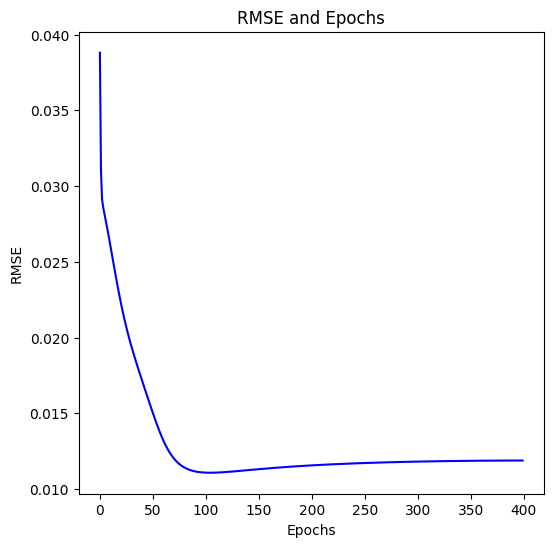

In [ ]:
#自訂隱藏層+one-hot-encoding
import numpy as np
import csv
import random
from matplotlib import pyplot as plt

def dlogsig(n,a):

    return a * (1-a)

def logsig(n):

    return 1 / (1 + np.exp(-1*n))

def purelin(n):

    return n

def dpurelin(n, a):

    return np.ones(np.size(n));

def add_bias(SUMs, bias):
  for row in SUMs:
    for col in row:
      col += random.uniform(-bias, bias)
  return SUMs

def weight_update(Input, weights, apha, bias, Target):
    SUMs = []
    A = [Input]
    DELTAs = []
    for weight in range(0, len(weights)):
      if weight == len(weights)-1:
        sum = A[weight] @ weights[weight]
        SUMs.append(sum)
        A.append(purelin(add_bias(sum, bias)))
      else:
        sum = A[weight] @ weights[weight]
        SUMs.append(sum)
        A.append(logsig(add_bias(sum, bias)))

    #先計算最後的DELTA
    DELTAs.append((Target - A[-1]) * dpurelin(SUMs[-1], A[-1]))
    for delta in range(1, len(SUMs)):
      #DELTAs = [DELTA3 DELTA2 DELTA1]
      #A = [Input A1 A2 A3]
      #SUMs = [SUM1 SUM2 SUM3]
      #weights = [W1 W2 W3]
      #DELTAs[N] = (DELTA[N-1] @ np.transpose(weights[N+1])) * dlogsig(SUM[N], A[N+1])
      DELTAs.append((DELTAs[delta-1] @ np.transpose(weights[len(A)-delta-1]) * dlogsig(SUMs[len(SUMs)-delta-1], A[len(A)-delta-1])))

    for weight in range(0, len(weights)):
      weights[weight] = weights[weight] + apha * np.transpose(np.transpose(DELTAs[len(DELTAs)-weight-1]) @ A[weight])

    return weights

def print_matrix(matrix):
  for row in matrix:
    for col in row:
      print(col, end=' ')
    print()
  print()
  print()

def classify(Aout):
  max = Aout[0]
  max_index = 0
  for num in range(0, len(Aout)):
    if Aout[num] > max:
      max = Aout[num]
      max_index = num

  return max_index+1

def train_model(Input, layers_and_neurons, learning_rate, bias, classify_amounts, epochs):
  apha = learning_rate
  epochs = epochs
  #注意矩陣維度輸入時的完整性
  weights = []
  neuron_every_layer = []
  neuron_every_layer.append([len(Input[0]), layers_and_neurons[0]])
  for layer in range(0, len(layers_and_neurons)-1):
    neuron_every_layer.append([layers_and_neurons[layer], layers_and_neurons[layer+1]])
  neuron_every_layer.append([layers_and_neurons[-1], classify_amounts])

  #權重初始化
  for n in neuron_every_layer:
    rows, cols = n
    w = []
    for row in range(0, rows):
      a_row = []
      for col in range(0, cols):
        a_row.append(random.uniform(-1, 1))
      w.append(a_row)
    w = np.array(w, dtype="float64")
    weights.append(w)

  RMSE_every_epoch = []
  for epoch in range(0, epochs):
    #一次epoch
    RMSE = [0, 0, 0]
    for data in range(0, 75):
      weights = weight_update([Input[data]], weights, apha, bias, [Target[data]])
      Aout = logsig([Input[data]]@weights[0])
      for i in range(1, len(weights)-1):
        Aout = logsig(Aout@weights[i])
      Aout = purelin(Aout@weights[-1])
      for classify_index in range(0, len(Target[data])):
        RMSE[classify_index] += (Target[data][classify_index] - Aout[0][classify_index])**2

    for classify_index in range(0, len(Target[data])):
      RMSE[classify_index] = RMSE[classify_index]**0.5

    RMSE = (sum(RMSE))/(75*classify_amounts)
    print("Epoch {:03}".format(epoch+1) + ":", "RMSE = {:.16f}".format(RMSE))
    RMSE_every_epoch.append(RMSE)

  #Test Data
  correct = 0
  outputs = []
  for data in range(75, 150):
    Aout = logsig([Input[data]]@weights[0])
    for i in range(1, len(weights)-1):
      Aout = logsig(Aout@weights[i])
    Aout = purelin(Aout@weights[-1])
    output = [Aout[0]]
    res = classify(Aout[0])
    if res == classify(Target[data]):
      output.append("True")
      correct += 1
    else:
      output.append("False")
    outputs.append(output)
  success = correct/75

  return success, RMSE_every_epoch, outputs

def read_Input_Target():
  Input = []
  #讀取CSV input
  with open('iris_in.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
      Input.append(row)
  Input = np.array(Input, dtype="float64")

  Target = []
  #讀取CSV target
  with open('iris_out.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)
    for row in rows:
      #改為one-hot-encoding
      if int(row[0][0]) == 1:
        Target.append([1, 0, 0])
      elif int(row[0][0]) == 2:
        Target.append([0, 1, 0])
      elif int(row[0][0]) == 3:
        Target.append([0, 0, 1])
      else:
        print("error occur when read target")
  Target = np.array(Target, dtype="float64")
  return Input, Target

if __name__ == '__main__':

  Input, Target = read_Input_Target()
  layers_and_neurons = [10]
  learning_rate = 0.15
  bias = 0.1
  classify_amounts = 3
  epochs = 400
  success, RMSE_every_epoch, outputs = train_model(Input, layers_and_neurons, learning_rate, bias, classify_amounts, epochs)

  #輸出test data的輸出結果
  print()
  for output in range(0, len(outputs)):
    print("資料" + "{:03}".format(output+76) + ":", end=' ')
    for index in outputs[output][0]:
      print("{:20.16f}".format(index), end=' ')
    print("Target:", int(classify(Target[output])), "Hit:", outputs[output][1])
  print(success)

  #劃出RMSE-Epochs圖
  plt.rcParams["figure.figsize"] = (6,6)
  plt.plot(RMSE_every_epoch,color = 'b')
  plt.title('RMSE and Epochs')
  plt.ylabel('RMSE')
  plt.xlabel('Epochs')
  plt.show()




Epoch 001: RMSE = 0.0937327465251750
Epoch 002: RMSE = 0.0719512031701719
Epoch 003: RMSE = 0.0589070965400222
Epoch 004: RMSE = 0.0448469437835568
Epoch 005: RMSE = 0.0346897189622696
Epoch 006: RMSE = 0.0298407860429568
Epoch 007: RMSE = 0.0279514633226097
Epoch 008: RMSE = 0.0270441496702303
Epoch 009: RMSE = 0.0263778773433684
Epoch 010: RMSE = 0.0257640793353001
Epoch 011: RMSE = 0.0251686567834781
Epoch 012: RMSE = 0.0245901857678190
Epoch 013: RMSE = 0.0240313430771979
Epoch 014: RMSE = 0.0234939314254715
Epoch 015: RMSE = 0.0229787435194452
Epoch 016: RMSE = 0.0224860209406499
Epoch 017: RMSE = 0.0220157681100954
Epoch 018: RMSE = 0.0215678987626656
Epoch 019: RMSE = 0.0211422856838316
Epoch 020: RMSE = 0.0207387660638604
Epoch 021: RMSE = 0.0203571306478971
Epoch 022: RMSE = 0.0199971098632161
Epoch 023: RMSE = 0.0196583623881620
Epoch 024: RMSE = 0.0193404680103122
Epoch 025: RMSE = 0.0190429250347987
Epoch 026: RMSE = 0.0187651518484117
Epoch 027: RMSE = 0.0185064919933243
E

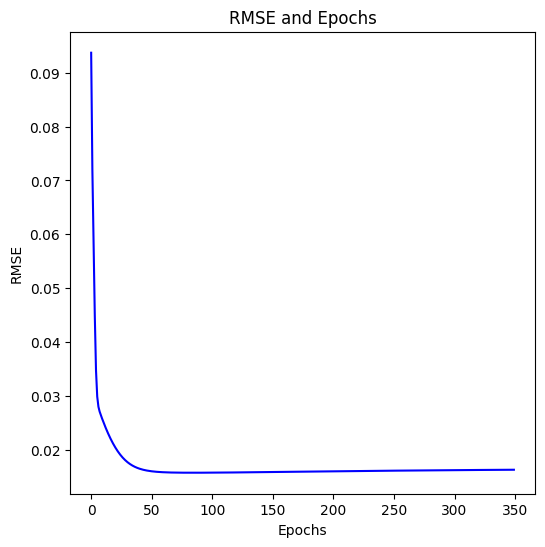

In [ ]:
#2層隱藏層
import numpy as np
import csv
import random
from matplotlib import pyplot as plt

def dlogsig(n,a):

    return a * (1-a)

def logsig(n):

    return 1 / (1 + np.exp(-1*n))

def purelin(n):

    return n

def dpurelin(n, a):

    return np.ones(np.size(n));

def add_bias(SUMs, bias):
  for row in SUMs:
    for col in row:
      col += random.uniform(-bias, bias)
  return SUMs

def weight_update(Input, W1, W2, W3, apha, Target):
    bias = 0.1
    SUM1 = Input @ W1
    A1 = logsig(add_bias(SUM1, bias))
    SUM2 = A1 @ W2
    A2 = logsig(add_bias(SUM2, bias))
    SUM3 = A2 @ W3
    A3 = purelin(add_bias(SUM3, bias))
    DELTA3 = (Target-A3)*dpurelin(SUM3, A3)
    DELTA2 = (DELTA3 @ np.transpose(W3)) * dlogsig(SUM2, A2)
    DELTA1 = (DELTA2 @ np.transpose(W2)) * dlogsig(SUM1, A1)
    W3 = W3 + apha*np.transpose(np.transpose(DELTA3) @ A2)
    W2 = W2 + apha*np.transpose(np.transpose(DELTA2) @ A1)
    W1 = W1 + apha*np.transpose(np.transpose(DELTA1) @ Input)
    return W1, W2, W3

def print_matrix(matrix):
  for row in matrix:
    for col in row:
      print(col, end=' ')
    print()
  print()
  print()

def classify(a_number):

  if 0.5 <= a_number < 1.5:
    return 1

  elif 1.5 <= a_number < 2.5:
    return 2

  elif 2.5 <= a_number < 3.5:
    return 3

  return 0

def train_model(layer_one_neuron_amount, layer_two_neuron_amount, learning_rate, epochs):
  apha = learning_rate
  epochs = epochs
  #注意矩陣維度輸入時的完整性
  W1 = []
  for row in range(0, 4):
    a_row = []
    for col in range(0, layer_one_neuron_amount):
      a_row.append(random.random()*2-1)
    W1.append(a_row)
  W1 = np.array(W1, dtype="float64")

  W2 = []
  for row in range(0, layer_one_neuron_amount):
    a_row = []
    for col in range(0, layer_two_neuron_amount):
      a_row.append(random.random()*2-1)
    W2.append(a_row)
  W2 = np.array(W2, dtype="float64")

  W3 = []
  for row in range(0, layer_two_neuron_amount):
    W3.append([random.random()*2-1])
  W3 = np.array(W3, dtype="float64")
  RMSE_every_epoch = []
  for epoch in range(0, epochs):
    #一次epoch
    RMSE = 0
    for data in range(0, 75):
      W1, W2, W3 = weight_update([Input[data]], W1, W2, W3, apha, [Target[data]])
      Aout = purelin(logsig(logsig([Input[data]]@W1)@W2)@W3)
      RMSE += (Aout[0][0] - Target[data])**2

    RMSE = (RMSE**0.5)/75
    RMSE = RMSE[0]
    print("Epoch {:03}".format(epoch+1) + ":", "RMSE = {:.16f}".format(RMSE))
    RMSE_every_epoch.append(RMSE)

  #Test Data
  correct = 0
  outputs = []
  for data in range(75, 150):
    Aout = purelin(logsig(logsig([Input[data]]@W1)@W2)@W3)
    res = Aout[0][0]
    output = [res]
    res = classify(res)
    if res == Target[data][0]:
      output.append("True")
      correct += 1
    else:
      output.append("False")
    outputs.append(output)
  success = correct/75

  return success, RMSE_every_epoch, outputs

Input = []
#讀取CSV input
with open('iris_in.csv', newline='') as csvfile:
  rows = csv.reader(csvfile)
  for row in rows:
    Input.append(row)
Input = np.array(Input, dtype="float64")

Target = []
#讀取CSV target
with open('iris_out.csv', newline='') as csvfile:
  rows = csv.reader(csvfile)
  for row in rows:
    Target.append(row)
Target = np.array(Target, dtype="float64")



success, RMSE_every_epoch, outputs = train_model(6, 3, 0.1, 350)
print()
for output in range(0, len(outputs)):
  print("資料" + "{:03}".format(output+76) + ":", "{:.16f}".format(outputs[output][0]), "Target:", int(Target[output][0]), "Hit:", outputs[output][1])
print("accuracy:", success)

#劃出RMSE-Epochs圖
plt.rcParams["figure.figsize"] = (6,6)
plt.plot(RMSE_every_epoch,color = 'b')
plt.title('RMSE and Epochs')
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.show()




資料76: 0.9586178659159107 0.02094111178349145 0.051305833827947955 
資料77: -0.025038494091514457 0.959977191832522 0.08320148156672325 
資料78: -0.011598242965745575 0.06169789624644306 0.9443099876650474 
資料79: 0.9604707639905108 0.010137022553298625 0.055505469006487784 
資料80: -0.045241862067489175 0.8609446224580201 0.17122482680727735 
資料81: -0.0016959891851165837 0.06677564888589849 0.9188452835053773 
資料82: 0.9587997427481545 0.00821923017611903 0.004591412355867686 
資料83: -0.015985671298823834 0.8011268527785557 0.2004367729389558 
資料84: 0.025115150107433384 -0.12307270813608007 1.0822698777274233 
資料85: 0.9783917608937085 -0.007607860760388441 0.025029207232604378 
資料86: 0.07499627252290714 1.0358114170766286 -0.08488922139348021 
資料87: 0.013477349380098813 0.014835396326800643 0.9455303336478802 
資料88: 0.9791351487911065 -0.005024131881274041 0.03779479996381152 
資料89: -0.022943974571685732 0.8404544899771568 0.19445638805740662 
資料90: 0.006052415545198822 -0.08357037717370214 1.1

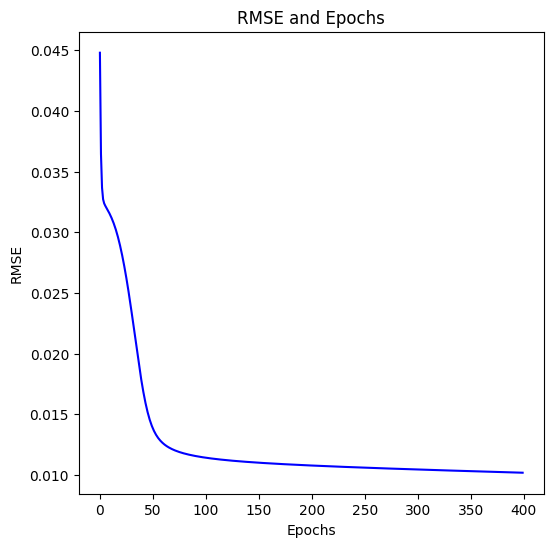

In [ ]:
#2層隱藏層+one-hot-encoding
import numpy as np
import csv
import random
from matplotlib import pyplot as plt

def dlogsig(n,a):

    return a * (1-a)

def logsig(n):

    return 1 / (1 + np.exp(-1*n))

def purelin(n):

    return n

def dpurelin(n, a):

    return np.ones(np.size(n));


def weight_update(Input, W1, W2, W3, apha, Target):
    bias = 0.1
    SUM1 = Input @ W1
    A1 = logsig(SUM1)
    SUM2 = A1 @ W2
    A2 = logsig(SUM2)
    SUM3 = A2 @ W3
    A3 = purelin(SUM3)
    DELTA3 = (Target-A3)*dpurelin(SUM3, A3+bias)
    DELTA2 = (DELTA3 @ np.transpose(W3)) * dlogsig(SUM2, A2+bias)
    DELTA1 = (DELTA2 @ np.transpose(W2)) * dlogsig(SUM1, A1+bias)
    W3 = W3 + apha*np.transpose(np.transpose(DELTA3) @ A2)
    W2 = W2 + apha*np.transpose(np.transpose(DELTA2) @ A1)
    W1 = W1 + apha*np.transpose(np.transpose(DELTA1) @ Input)
    return W1, W2, W3

def print_matrix(matrix):
  for row in matrix:
    for col in row:
      print(col, end=' ')
    print()
  print()
  print()

def classify(Aout):
  max = Aout[0]
  max_index = 0
  for num in range(0, len(Aout)):
    if Aout[num] > max:
      max = Aout[num]
      max_index = num

  return max_index+1

def train_model(Input, layer_one_neuron_amount, layer_two_neuron_amount, learning_rate, classify_amounts, epochs):
  apha = learning_rate
  epochs = epochs
  #注意矩陣維度輸入時的完整性
  W1 = []
  for row in range(0, 4):
    a_row = []
    for col in range(0, layer_one_neuron_amount):
      a_row.append(random.randint(0, 1)*2-1)
    W1.append(a_row)
  W1 = np.array(W1, dtype="float64")

  W2 = []
  for row in range(0, layer_one_neuron_amount):
    a_row = []
    for col in range(0, layer_two_neuron_amount):
      a_row.append(random.randint(0, 1)*2-1)
    W2.append(a_row)
  W2 = np.array(W2, dtype="float64")

  W3 = []
  for row in range(0, layer_two_neuron_amount):
    a_row = []
    for col in range(0, classify_amounts):
      #3個output
      a_row.append(random.randint(0, 1)*2-1)
    W3.append(a_row)
  W3 = np.array(W3, dtype="float64")

  RMSE_every_epoch = []
  for epoch in range(0, epochs):
    #一次epoch
    RMSE = [0, 0, 0]
    for data in range(0, 75):
      W1, W2, W3 = weight_update([Input[data]], W1, W2, W3, apha, [Target[data]])
      Aout = purelin(logsig(logsig([Input[data]]@W1)@W2)@W3)
      for classify_index in range(0, len(Target[data])):
        RMSE[classify_index] += (Target[data][classify_index] - Aout[0][classify_index])**2

    for classify_index in range(0, len(Target[data])):
      RMSE[classify_index] = RMSE[classify_index]**0.5

    RMSE = (sum(RMSE)/classify_amounts)/(75)

    RMSE_every_epoch.append(RMSE)

  #Test Data
  correct = 0
  outputs = []
  for data in range(75, 150):
    Aout = purelin(logsig(logsig([Input[data]]@W1)@W2)@W3)
    outputs.append(Aout[0])
    res = classify(Aout[0])
    if res == classify(Target[data]):
      correct += 1
  success = correct/75

  return success, RMSE_every_epoch, outputs

Input = []
#讀取CSV input
with open('iris_in.csv', newline='') as csvfile:
  rows = csv.reader(csvfile)
  for row in rows:
    Input.append(row)
Input = np.array(Input, dtype="float64")

Target = []
#讀取CSV target
with open('iris_out.csv', newline='') as csvfile:
  rows = csv.reader(csvfile)
  for row in rows:
    #改為one-hot-encoding
    if int(row[0][0]) == 1:
      Target.append([1, 0, 0])
    elif int(row[0][0]) == 2:
      Target.append([0, 1, 0])
    elif int(row[0][0]) == 3:
      Target.append([0, 0, 1])
    else:
      print("error occur when read target")
Target = np.array(Target, dtype="float64")



success, RMSE_every_epoch, outputs = train_model(Input, 10, 5, 0.1, 3, 400)
for output in range(0, len(outputs)):
  print("資料" + str(output+76) + ":", end=' ')
  for index in outputs[output]:
    print(index, end=' ')
  print()
print("accuracy:", success)

#劃出RMSE-Epochs圖
plt.rcParams["figure.figsize"] = (6,6)
plt.plot(RMSE_every_epoch,color = 'b')
plt.title('RMSE and Epochs')
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.show()




0.96


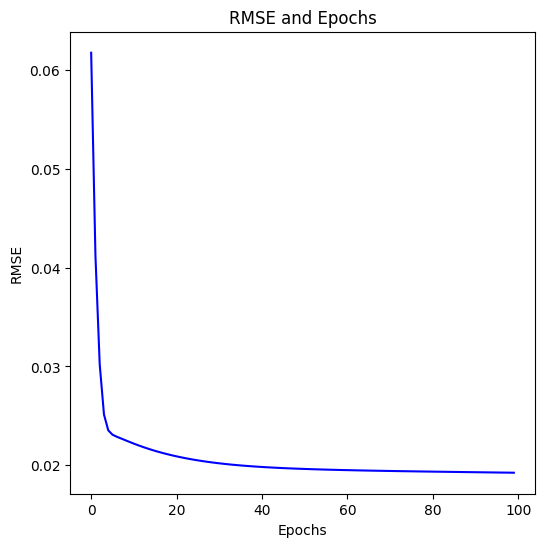

In [ ]:
#1層隱藏層
import numpy as np
import csv
import random
from matplotlib import pyplot as plt

def dlogsig(n,a):

    return a * (1-a)

def logsig(n):

    return 1 / (1 + np.exp(-1*n))

def purelin(n):

    return n

def dpurelin(n, a):

    return np.ones(np.size(n));


def weight_update(Input, Whid, Wout, apha, Target):
    bias = 0.01
    SUMhid = Input @  Whid
    Ahid =  logsig(SUMhid)
    SUMout = Ahid @ Wout
    Aout = purelin(SUMout)
    DELTAout = (Target-Aout)*dpurelin(SUMout, Aout+bias)
    DELTAhid = DELTAout @ np.transpose(Wout)
    Wout = Wout + np.transpose(np.transpose(DELTAout) @ Ahid)*apha
    Whid = Whid + np.transpose(np.transpose(DELTAhid*dlogsig(SUMhid, Ahid+bias)) @ Input)*apha

    return Whid, Wout

def print_matrix(matrix):
  for row in matrix:
    for col in row:
      print(col, end=' ')
    print()
  print()
  print()

def classify(a_number):

  if 0.5 <= a_number < 1.5:
    return 1

  elif 1.5 <= a_number < 2.5:
    return 2

  elif 2.5 <= a_number < 3.5:
    return 3

  return 0

def train_model(neuron_amount, learning_rate, epochs):
  neuron_amount = neuron_amount
  apha = learning_rate
  epochs = epochs
  #注意矩陣維度輸入時的完整性
  Whid = []
  for row in range(0, 4):
    a_row = []
    for col in range(0, neuron_amount):
      a_row.append(random.random()*2-1)
    Whid.append(a_row)
  Whid = np.array(Whid, dtype="float64")

  Wout = []
  for row in range(0, neuron_amount):
    Wout.append([random.random()*2-1])
  Wout = np.array(Wout, dtype="float64")

  RMSE_every_epoch = []
  for epoch in range(0, epochs):
    #一次epoch
    RMSE = 0
    for data in range(0, 75):
      Whid, Wout = weight_update([Input[data]], Whid, Wout, apha, [Target[data]])
      Aout = purelin(logsig([Input[data]]@Whid)@Wout)
      RMSE += (Aout[0][0] - Target[data])*(Aout[0][0] - Target[data])

    RMSE = (RMSE**0.5)/75
    RMSE_every_epoch.append(RMSE)

  #Test Data
  correct = 0
  for data in range(75, 150):
    Aout = purelin(logsig([Input[data]]@Whid)@Wout)
    res = classify(Aout[0][0])
    if res == Target[data][0]:
      correct += 1
  success = correct/75

  return success, RMSE_every_epoch

Input = []
#讀取CSV input
with open('iris_in.csv', newline='') as csvfile:
  rows = csv.reader(csvfile)
  for row in rows:
    Input.append(row)
Input = np.array(Input, dtype="float64")

Target = []
#讀取CSV target
with open('iris_out.csv', newline='') as csvfile:
  rows = csv.reader(csvfile)
  for row in rows:
    Target.append(row)
Target = np.array(Target, dtype="float64")



success, RMSE_every_epoch = train_model(6, 0.1, 100)
print(success)

#劃出RMSE-Epochs圖
plt.rcParams["figure.figsize"] = (6,6)
plt.plot(RMSE_every_epoch,color = 'b')
plt.title('RMSE and Epochs')
plt.ylabel('RMSE')
plt.xlabel('Epochs')
plt.show()


